In [194]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio
import math
import sys
from matplotlib.patches import Polygon

from CST import CST
from Node import Node
from units import mm, cm, m, kgf, N, tf, kN, MPa, GPa
from fem import Material, Membrane, Section
from functions import matrix_extract,  get_nodes_from_physical_id, get_line_load_global_vector, matrix_replace
from structuresolver import StructureSolver


First we create a mesh file based on the wrench2.geo file

In [195]:
geo_file = "wrench2.geo"
lc = 5
gmsh.initialize()
gmsh.open(geo_file)
gmsh.model.geo.synchronize()
# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(geo_file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
gmsh.fltk.run()

gmsh.finalize()



Then, we create all the material properties

In [ ]:
PLA=Material.Material(name='PLA',
             E=3.0*GPa,
             nu=0.40,
             rho=1.25*tf/m**3)

# Definimos una seccion de la membrana
Heads_M=Membrane.Membrane(name='Cabeza5mm',
              thickness=5*mm,
              material=PLA)
Handle_big_M=Membrane.Membrane(name='Cuerpo3mm',
               thickness=3*mm,
               material=PLA)
Handle_thin_M=Membrane.Membrane(name='Cuerpo1.6mm',
                 thickness=1.6*mm,
                 material=PLA)

# Definimos los grupos fisicos de las partes del modelo
# Map the physical group id to a section
section_dict={"Heads":Heads_M,
              "Handle_big":Handle_big_M,
              "Handle_thin":Handle_thin_M}
            

In [197]:
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")


Block 0 - Tipo: line, Cantidad: 5, Physical tags: {np.int64(129)}
Block 1 - Tipo: line, Cantidad: 4, Physical tags: {np.int64(130)}
Block 2 - Tipo: line, Cantidad: 4, Physical tags: {np.int64(130)}
Block 3 - Tipo: triangle, Cantidad: 58, Physical tags: {np.int64(123)}
Block 4 - Tipo: triangle, Cantidad: 59, Physical tags: {np.int64(123)}
Block 5 - Tipo: triangle, Cantidad: 117, Physical tags: {np.int64(124)}
Block 6 - Tipo: triangle, Cantidad: 57, Physical tags: {np.int64(125)}


Now is necessary to group the nodes in differnt groups. In this case, there are 3 groups: Heads, handle_big and handle_thin

In [198]:
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}
Materials = {}
# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")

        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id+1, (x, y)))


# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = ["f", "f"]
            if nombre in ["Nut"]:
                print(f"Grupo {nombre} - Nodo {node_id+1} - Coordenadas ({x}, {y})")
                restrain = ["r", "r"]
            grupos[nombre].append(Node(node_id+1, (x, y), restrain=restrain))


   


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.name] = n
    grupos[nombre] = list(nodos_unicos.values())




Grupo Nut - Nodo 18 - Coordenadas (-49.59630457404682, -7.007006434074835)
Grupo Nut - Nodo 108 - Coordenadas (-53.7542219025252, -8.278209332359298)
Grupo Nut - Nodo 108 - Coordenadas (-53.7542219025252, -8.278209332359298)
Grupo Nut - Nodo 109 - Coordenadas (-57.91213923100359, -9.549412230643764)
Grupo Nut - Nodo 109 - Coordenadas (-57.91213923100359, -9.549412230643764)
Grupo Nut - Nodo 110 - Coordenadas (-62.07005655948195, -10.82061512892822)
Grupo Nut - Nodo 110 - Coordenadas (-62.07005655948195, -10.82061512892822)
Grupo Nut - Nodo 19 - Coordenadas (-66.22797388796032, -12.09181802721268)
Grupo Nut - Nodo 20 - Coordenadas (-71.19829286824671, 4.165362824158498)
Grupo Nut - Nodo 121 - Coordenadas (-67.04037553976833, 5.436565722442968)
Grupo Nut - Nodo 121 - Coordenadas (-67.04037553976833, 5.436565722442968)
Grupo Nut - Nodo 122 - Coordenadas (-62.88245821128994, 6.707768620727439)
Grupo Nut - Nodo 122 - Coordenadas (-62.88245821128994, 6.707768620727439)
Grupo Nut - Nodo 123 

In [199]:
thicknes= {
    "Heads": 5.0*mm,
    "Handle_big": 3.0*mm,
    "Handle_thin": 1.6*mm  # o lo que corresponda, si es zona de carga quizás se ignora
}


sections = {}
for group in thicknes:
    sections[group] = Section.Section(thicknes[group], Ex=3000, Ey=1200, nuxy=0.35, Gxy=500)
    


In [200]:
nodes_dict = {}
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.name] = node

In [201]:
triangles = mesh.cells_dict['triangle']
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []
nodes = set()

for i in range(len(tags)):
    tag = tags[i]
    group_name = tag_to_name[tag]
    if group_name not in sections:
        continue  # Saltar elementos sin sección (como 'Force' o 'Nut')

    section = sections[group_name]
    material= section_dict[group_name]
    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]+1]
    nodo_b = nodes_dict[node_ids[1]+1]
    nodo_c = nodes_dict[node_ids[2]+1]



    for nodo in [nodo_a, nodo_b, nodo_c]:
        nodes.add(nodo)
        if np.all(nodo.restrain == ["r", "r"]):
            print(f"Nodo {nodo.name} con restricción total está en elemento {i+1}")


    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section=material)
    elements.append(elem)

nodes = list(nodes)


Nodo 110 con restricción total está en elemento 72
Nodo 19 con restricción total está en elemento 72
Nodo 20 con restricción total está en elemento 73
Nodo 121 con restricción total está en elemento 73
Nodo 21 con restricción total está en elemento 78
Nodo 108 con restricción total está en elemento 80
Nodo 18 con restricción total está en elemento 85
Nodo 108 con restricción total está en elemento 86
Nodo 18 con restricción total está en elemento 86
Nodo 110 con restricción total está en elemento 90
Nodo 21 con restricción total está en elemento 92
Nodo 123 con restricción total está en elemento 92
Nodo 123 con restricción total está en elemento 93
Nodo 121 con restricción total está en elemento 94
Nodo 109 con restricción total está en elemento 95
Nodo 108 con restricción total está en elemento 95
Nodo 123 con restricción total está en elemento 96
Nodo 122 con restricción total está en elemento 96
Nodo 110 con restricción total está en elemento 97
Nodo 109 con restricción total está e

Here we plot the element, and see if the nodes that are restrain (Nut) or have a force applied (Force) are identified and plotted

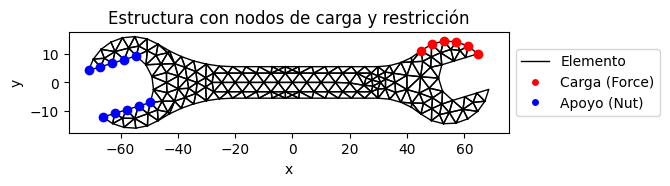

In [202]:

x = np.array([node.coordenadas[0] for node in nodes])
y = np.array([node.coordenadas[1] for node in nodes])

# Mapeo name → índice
node_index_map = {node.name: i for i, node in enumerate(nodes)}

# Gráfico
fig, ax = plt.subplots(figsize=(8, 6))

for elem in elements:
    indices = [node_index_map[node.name] for node in elem.node_list]
    coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
    ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

# Dibujar nodos del grupo "Force" (en rojo)
for i, node in enumerate(grupos["Force"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'ro', markersize=6, label="Carga (Force)" if i == 0 else "")

# Dibujar nodos del grupo "Nut" (en azul)
for i, node in enumerate(grupos["Nut"]):
    idx = node_index_map[node.name]
    ax.plot(x[idx], y[idx], 'bo', markersize=6, label="Apoyo (Nut)" if i == 0 else "")

# Gráfico final
ax.set_title("Estructura con nodos de carga y restricción")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

ax.legend(
    handles=[
        plt.Line2D([0], [0], color='k', lw=1, label='Elemento'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Carga (Force)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=6, label='Apoyo (Nut)')
    ],
    loc="center left",
    bbox_to_anchor=(1.0, 0.5)  # 📌 esto lo pone fuera del eje
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [203]:
def solve(nodes, elements):
    """
    Resuelve el sistema FEM considerando cargas distribuidas en líneas.

    Args:
        nodes (list): Lista de nodos con .idx, .nodalLoad, .restrain
        elements (list): Lista de elementos con .kg, .idx
        mesh: Objeto meshio con malla y etiquetas físicas
        load_dictionary (dict): Dict {id_físico: valor_carga}

    Returns:
        u (np.ndarray): Desplazamientos globales
        F_reactions (np.ndarray): Reacciones en DOFs restringidos
        Fj (np.ndarray): Fuerzas nodales aplicadas
        F_total (np.ndarray): Fuerzas totales incluyendo reacciones
    """
    nNodes = len(nodes)
    system_nDof = 2 * nNodes  # 2 DOFs por nodo

    # === CARGAS DISTRIBUIDAS EN LÍNEAS ===
    F_line_global = np.zeros(system_nDof)
    Fj = np.zeros(system_nDof)
    for node in nodes:
        for dof_idx, force in zip(node.idx, node.nodalLoad):
            Fj[dof_idx] = force



    # === MATRIZ DE RIGIDEZ GLOBAL ===
    Kg = np.zeros((system_nDof, system_nDof))
    for element in elements:
        Kg = matrix_replace(Kg, element.kg, element.idx, element.idx)


    # === RESTRICCIONES ===
    nodeIndex = np.full(system_nDof, '', dtype=str)
    for node in nodes:
        for dof_idx, status in zip(node.idx, node.restrain):
            nodeIndex[dof_idx] = status

    freeIndices = np.where(nodeIndex == 'f')[0]
    restrainedIndices = np.where(nodeIndex == 'r')[0]

    # === PARTICIÓN DEL SISTEMA ===
    Kff = matrix_extract(Kg, freeIndices, freeIndices)
    Kfr = matrix_extract(Kg, freeIndices, restrainedIndices)
    Krf = matrix_extract(Kg, restrainedIndices, freeIndices)
    Krr = matrix_extract(Kg, restrainedIndices, restrainedIndices)

    # === FUERZA TOTAL (aplicada + distribuida) ===
    F = Fj + F_line_global
    Ff = F[freeIndices]
    Fr = F[restrainedIndices]

    # === SOLUCIÓN ===
    uf = np.linalg.solve(Kff, Ff - Kfr @ Fr)
    ur = np.zeros(len(restrainedIndices))

    u = np.zeros(system_nDof)
    u[freeIndices] = uf
    u[restrainedIndices] = ur


    # === REACCIONES ===
    Fr = Krf @ uf + Krr @ ur
    F_reactions = np.zeros(system_nDof)
    F_reactions[restrainedIndices] = Fr


    return u


De aquí para abajo empieza la configuración de las fuerzas:

1er caso: Fuerza distribuida

2do caso: Fuerza puntual

3er caso: Fuerza distribuida con peso propio

Primer Caso: Fuerza distribuida

In [204]:
def apply_distributed_force(grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos no alineados.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 2: calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0]- nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[0]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Paso 3: calcular carga distribuida por unidad de longitud
    q_total = fuerza_total_y  # Fuerza total a repartir
    q_lineal = q_total / total_length  # N/m

    # Paso 4: aplicar cargas parciales a cada nodo (2 nodos por segmento)
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia abajo)
        nx = -vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componente de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        dof_x, dof_y = node.idx
        node.set_nodalLoad([fx,fy])

Acá se define el segundo caso: Fuerza puntual

In [205]:
def single_force(nodes, grupo_nodos, fuerza_total_y):
    """
    Aplica una fuerza puntual vertical (por ejemplo, peso) sobre un nodo específico.
    La fuerza se descompone en x e y.
    """
    for j in nodes:
        j.set_nodalLoad([0,0])
    # Paso 1: ordena nodos si es necesario (aquí asumimos que ya están ordenados)
    nodos = grupo_nodos


    # Paso 2: escoger un nodo específico (por ejemplo, el primero)
    nodo = nodos[0]  # Cambia esto si deseas otro nodo
    x, y = nodo.coordenadas[0], nodo.coordenadas[1]
    # Paso 3: aplicar carga puntual
    # Fuerza total a aplicar
    F_total = fuerza_total_y  # N
    # Componente de fuerza en x y y (globales)
    fx = 0.0  # Cambia esto si deseas una fuerza en x
    fy = F_total  # Fuerza en y
    nodo.set_nodalLoad([0,-fy])


In [206]:
def apply_distributed_force_especial(grupos, elementos, fuerza_total_y):
    for element in elementos:

        centroid = element.get_centroid()

        area= element.area

        thickness=element.section.thickness/100

        rho=element.section.material.rho

        weight= area * thickness * rho * 9.81


        F_interna = element.body_weight_forces(x=centroid[0], y=centroid[1],force_vector=[0, weight])/3
        node_a = element.node_list[0]
        node_b = element.node_list[1]
        node_c = element.node_list[2]

        if node_a.nodalLoad[0] == 0 and node_a.nodalLoad[1] == 0:
            node_a.set_nodalLoad([F_interna[0], -F_interna[1]])
        else:
            node_a.set_nodalLoad([node_a.nodalLoad[0] + F_interna[0], node_a.nodalLoad[1] - F_interna[1]])
        if node_b.nodalLoad[0] == 0 and node_b.nodalLoad[1] == 0:   
            node_b.set_nodalLoad([F_interna[0], -F_interna[1]])
        else:
            node_b.set_nodalLoad([node_b.nodalLoad[0] + F_interna[0], node_b.nodalLoad[1] - F_interna[1]])
        if node_c.nodalLoad[0] == 0 and node_c.nodalLoad[1] == 0:
            node_c.set_nodalLoad([F_interna[0], -F_interna[1]])
        else:
            node_c.set_nodalLoad([node_c.nodalLoad[0] + F_interna[0], node_c.nodalLoad[1] - F_interna[1]])
        
    if "Force" in grupos:
        nodos_fuerza = grupos["Force"]

    nodos = nodos_fuerza
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 2: calcular longitud total de la línea
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coordenadas[0]- nodos[i].coordenadas[0]
        dy = nodos[i+1].coordenadas[1] - nodos[i].coordenadas[0]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    # Paso 3: calcular carga distribuida por unidad de longitud
    q_total = fuerza_total_y  # Fuerza total a repartir
    q_lineal = q_total / total_length  # N/m

    # Paso 4: aplicar cargas parciales a cada nodo (2 nodos por segmento)
    nodal_forces = {node.name: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coordenadas[0], ni.coordenadas[1]
        xj, yj = nj.coordenadas[0], nj.coordenadas[1]

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Dirección normalizada del tramo (unitario)
        vx = dx / L
        vy = dy / L

        # Vector perpendicular (hacia abajo)
        nx = -vy
        ny = vx

        # Fuerza total sobre el tramo
        Fi = q_lineal * L  # Total fuerza sobre el tramo

        # Componente de fuerza en x y y (globales)
        fx = Fi * nx
        fy = Fi * ny

        # Distribuir mitad a cada nodo
        nodal_forces[ni.name] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.name] += np.array([fx / 2, fy / 2])
    for node in nodos:
        fx, fy = nodal_forces[node.name]
        f_px, f_py= node.nodalLoad[0], node.nodalLoad[1]
        node.set_nodalLoad([fx+f_px,fy+f_py])

In [241]:
def ensure_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
def compute_stress_strain_components(elements, u):
    results = []

    for elem in elements:
        # Obtener tensiones y deformaciones
        sigma, epsilon, _ = elem.get_element_stress(u)  # σxx, σyy, σxy
        exx, eyy, exy = epsilon
        sxx, syy, sxy = sigma

        # Deformaciones principales
        avg_eps = 0.5 * (exx + eyy)
        rad_eps = np.sqrt(((exx - eyy) / 2) ** 2 + exy ** 2)
        eps1 = avg_eps + rad_eps
        eps2 = avg_eps - rad_eps

        # Tensiones principales
        avg_sig = 0.5 * (sxx + syy)
        rad_sig = np.sqrt(((sxx - syy) / 2) ** 2 + sxy ** 2)
        sig1 = avg_sig + rad_sig
        sig2 = avg_sig - rad_sig

        results.append({
            "element": elem.element_tag,
            "σxx": sxx, "σyy": syy, "σxy": sxy,
            "εxx": exx, "εyy": eyy, "εxy": exy,
            "σ1": sig1, "σ2": sig2,
            "ε1": eps1, "ε2": eps2
        })

    return results
def average_element_values_to_nodes(nodes, elements, element_values):
    """
    Convierte valores definidos por elemento (por ejemplo σ1) en valores nodales por promedio.
    """
    from collections import defaultdict

    # Suma de valores y conteo
    val_sum = defaultdict(float)
    val_count = defaultdict(int)

    for elem, val in zip(elements, element_values):
        for node in elem.node_list:
            val_sum[node.name] += val
            val_count[node.name] += 1

    # Asignar promedio a cada nodo
    node_id_to_avg = {
        nid: val_sum[nid] / val_count[nid] for nid in val_sum
    }

    # Generar array en orden de nodos
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}
    nodal_values = np.array([
        node_id_to_avg[node.name] for node in nodes
    ])

    return nodal_values
import matplotlib.tri as mtri
def plot_scalar_field_on_mesh(nodes, elements, values, title, folder="figuras", filename=None, cmap="viridis"):
    """
    nodes: lista de nodos (cada uno con .id, .x, .y)
    elements: lista de elementos CST (con .node_list)
    values: lista de valores escalares por elemento (1 valor por elemento)
    """
    # Mapear ids de nodo a índice
    node_id_to_index = {node.name: i for i, node in enumerate(nodes)}

    # Coordenadas
    xs = [node.coordenadas[0] for node in nodes]
    ys = [node.coordenadas[1] for node in nodes]

    # Triángulos como lista de índices
    triangles = [
        [node_id_to_index[n.name] for n in elem.node_list]
        for elem in elements
    ]

    # Valor por triángulo → convertir a array
    values = np.array(values)

    # Crear triangulación
    triang = mtri.Triangulation(xs, ys, triangles)

    # Graficar
    plt.figure(figsize=(8, 6))
    tcf = plt.tricontourf(triang, values, cmap=cmap)
    plt.colorbar(tcf, label=title)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect("equal")
    plt.tight_layout()

    # Guardar imagen
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)

def plot_all_fields(results, nodes, elements, i):
    fields = ["σxx", "σyy", "σxy", "σ1", "σ2", "εxx", "εyy", "εxy", "ε1", "ε2"]
    titles = {
        "σxx": "Esfuerzo σxx", "σyy": "Esfuerzo σyy", "σxy": "Esfuerzo σxy",
        "σ1": "Esfuerzo Principal Máximo σ1", "σ2": "Esfuerzo Principal Mínimo σ2",
        "εxx": "Deformación εxx", "εyy": "Deformación εyy", "εxy": "Deformación εxy",
        "ε1": "Deformación Principal Máxima ε1", "ε2": "Deformación Principal Mínima ε2"
    }

    caso = f"Caso {i+1}"

    for field in fields:
        element_values = [res[field] for res in results]
        nodal_values = average_element_values_to_nodes(nodes, elements, element_values)
        plot_scalar_field_on_mesh(nodes, elements, nodal_values, f"{caso} — {titles[field]}", folder="Resultados")


In [ ]:
def plot_deformed_shape(nodes, elements, u, contador, scale, folder="figuras"):
    """
    Dibuja la estructura deformada y original, marcando nodos cargados y restringidos.

    Args:
        nodes (list): lista de nodos con .coordenadas, .name, .idx
        elements (list): lista de elementos con .node_list
        u (np.ndarray): vector de desplazamientos global
        contador (int): índice del caso (0, 1, 2)
        scale (float): factor de amplificación de la deformación
    """
    filename = None
    # Inicializar vectores de coordenadas
    n = len(nodes)
    x = np.zeros(n)
    y = np.zeros(n)
    x_def = np.zeros(n)
    y_def = np.zeros(n)

    # Construcción coordenadas originales y deformadas usando node.idx
    for i, node in enumerate(nodes):
        x[i] = node.coordenadas[0]
        y[i] = node.coordenadas[1]
        x_def[i] = x[i] + scale * u[node.idx[0]]
        y_def[i] = y[i] + scale * u[node.idx[1]]

    # Mapeo name → índice en array
    node_index_map = {node.name: i for i, node in enumerate(nodes)}


    # Gráfico
    fig, ax = plt.subplots(figsize=(8, 6))

    # Estructura original (negro)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x[i], y[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

    # Estructura deformada (rojo punteado)
    for elem in elements:
        indices = [node_index_map[node.name] for node in elem.node_list]
        coords = np.array([[x_def[i], y_def[i]] for i in indices + [indices[0]]])
        ax.plot(coords[:, 0], coords[:, 1], 'r--', linewidth=1)



    # Título dinámico por caso
    if contador == 0:
        title="Estructura deformada - Caso 1"
        ax.set_title(title)
    elif contador == 1:
        title="Estructura deformada - Caso 2"
        ax.set_title(title)
    elif contador == 2:
        title="Estructura deformada - Caso 3"
        ax.set_title(title)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")

    # Leyenda fuera del gráfico
    ax.legend(
        handles=[
            plt.Line2D([0], [0], color='k', lw=1, label='Elemento'),
            plt.Line2D([0], [0], linestyle='--', color='r', lw=1, label='Deformada')
        ],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    ensure_dir(folder)
    if filename is None:
        filename = title.replace(" ", "_").replace("—", "-") + ".png"
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath, dpi=300)

📸 Guardado: Resultados\Estructura_deformada_-_Caso_1.png
📸 Guardado: Resultados\Estructura_deformada_-_Caso_2.png


C:\Users\HP\AppData\Local\Temp\ipykernel_18360\3323524199.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


📸 Guardado: Resultados\Estructura_deformada_-_Caso_3.png


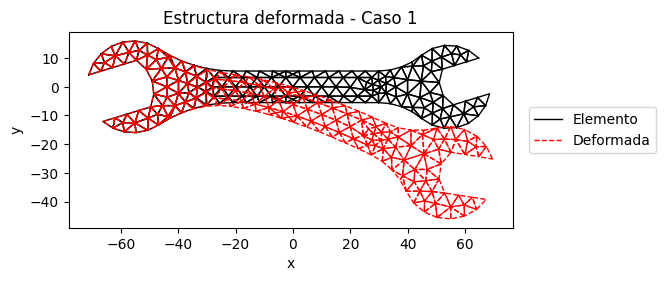

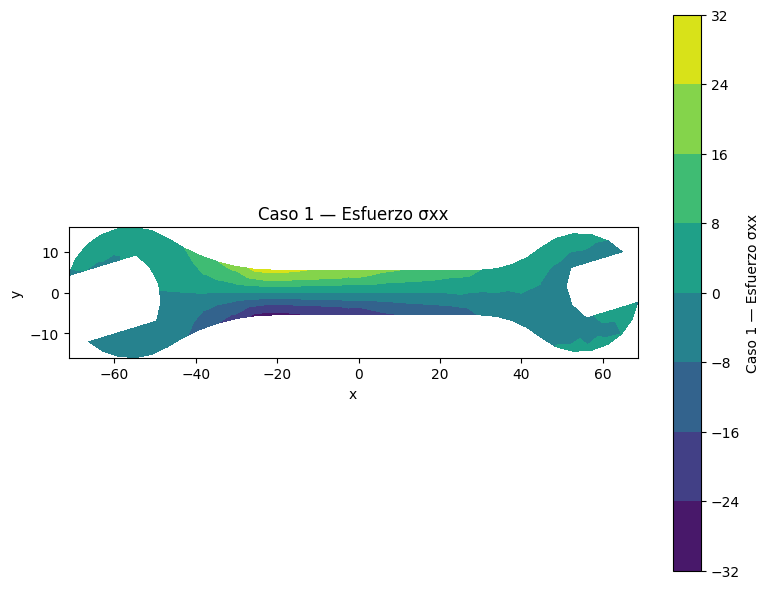

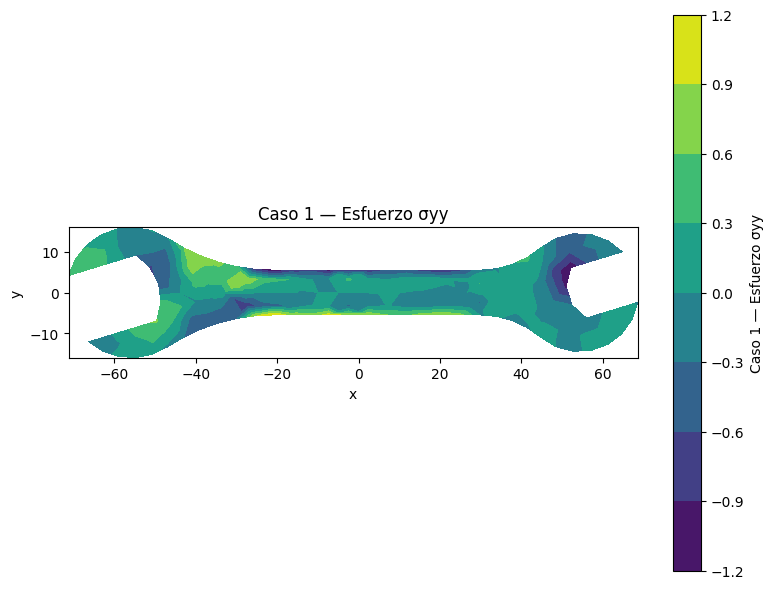

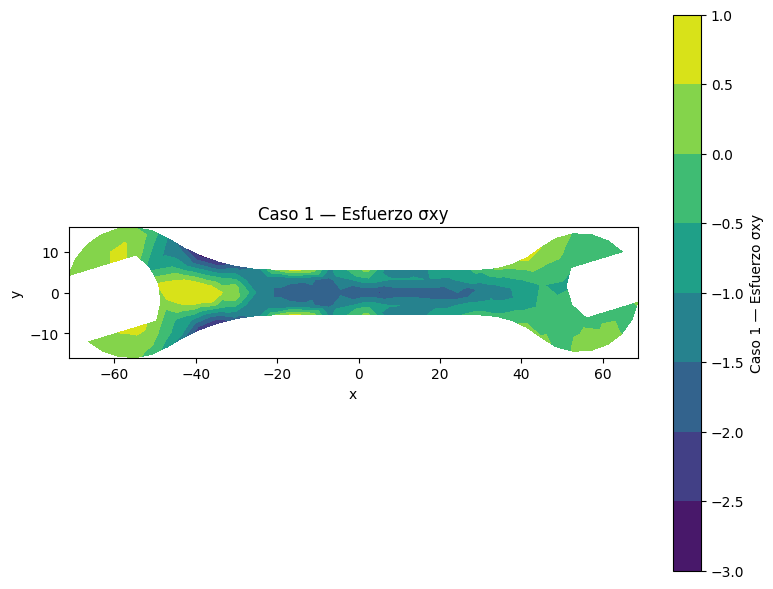

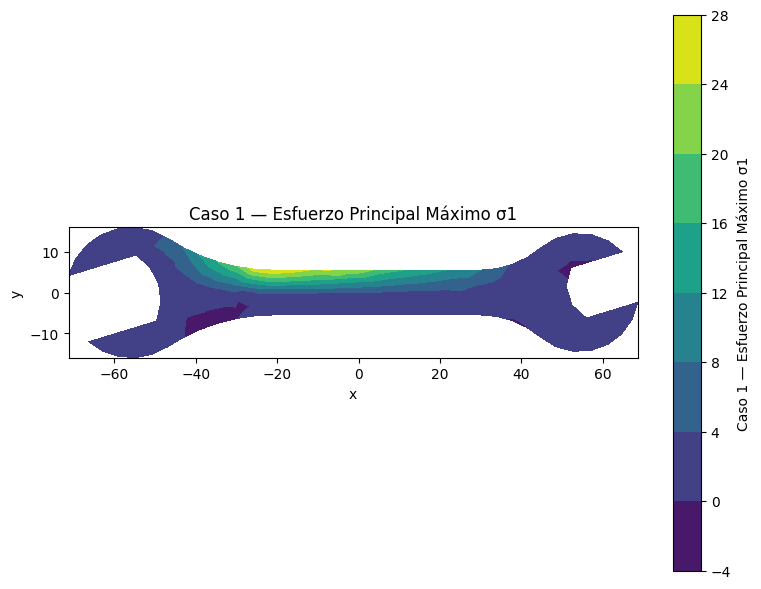

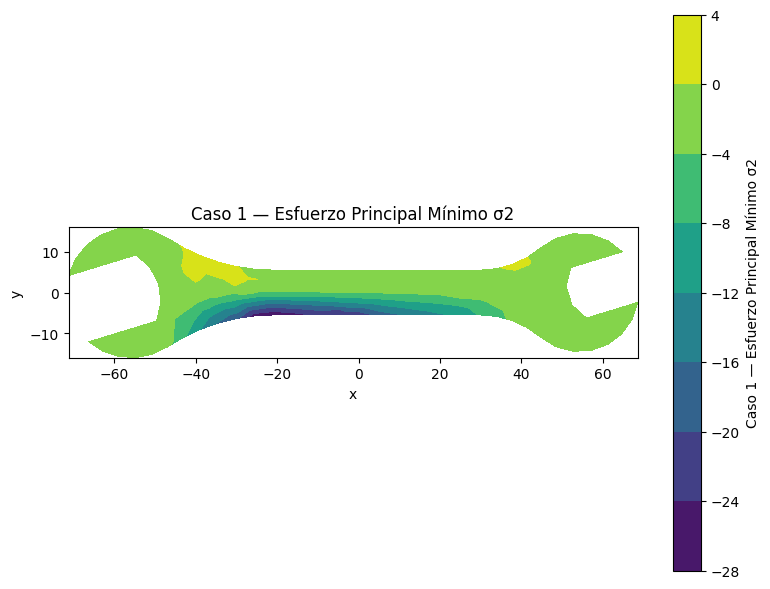

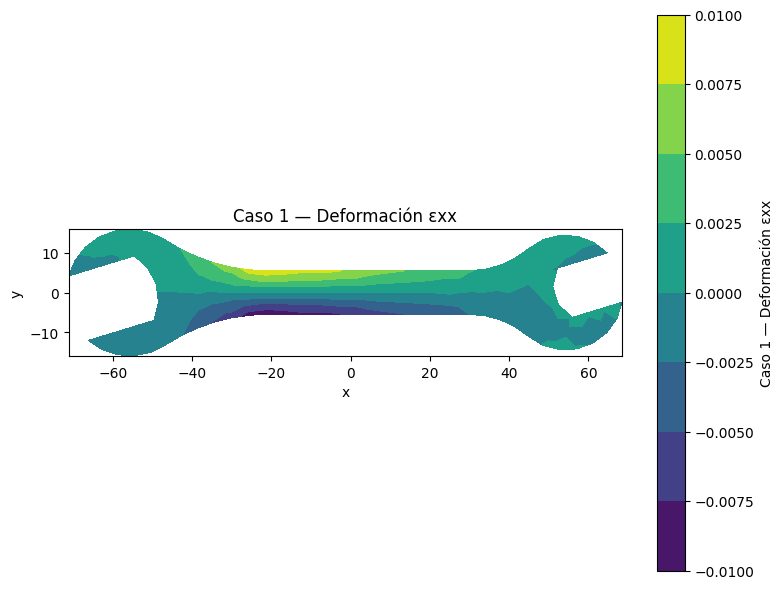

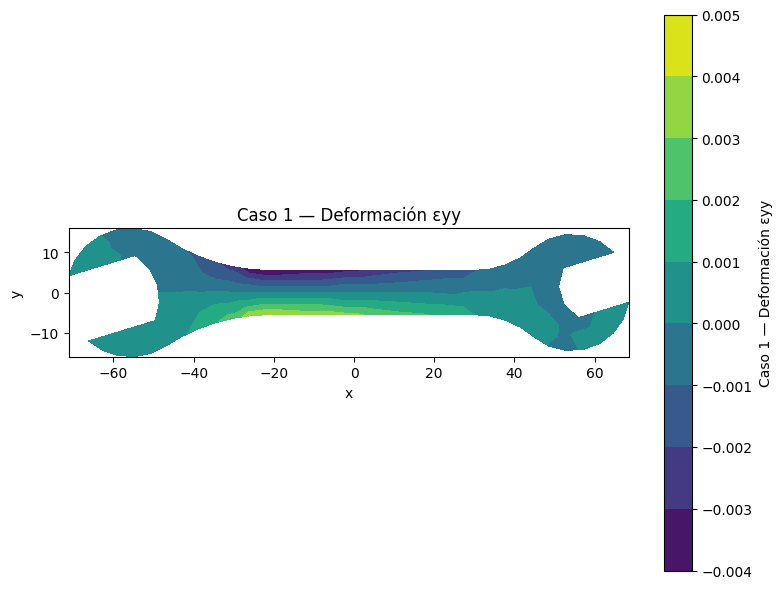

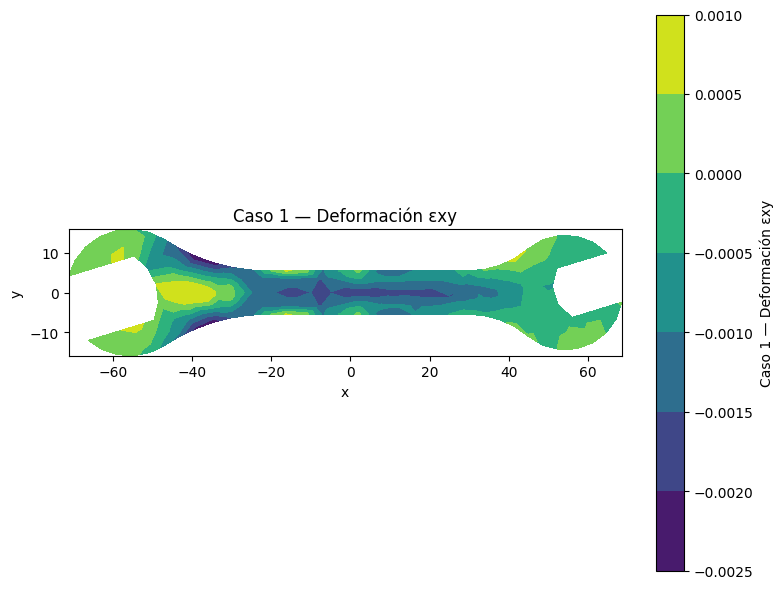

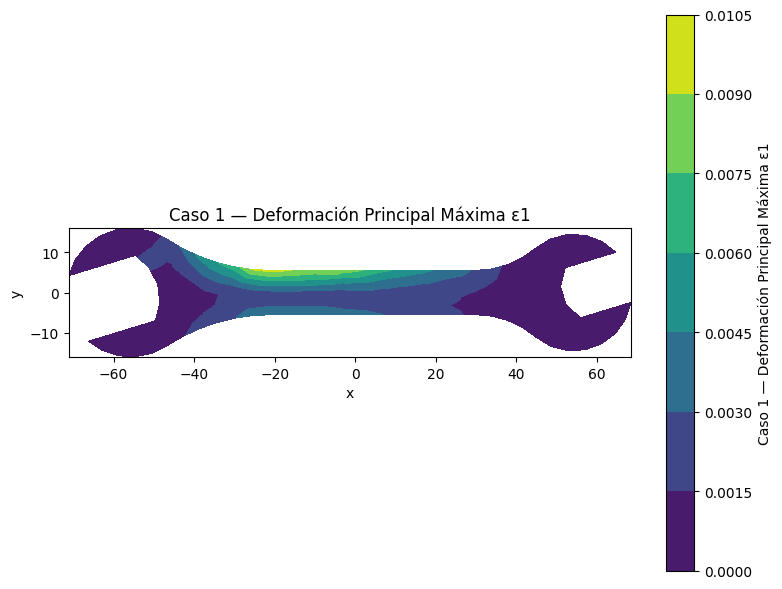

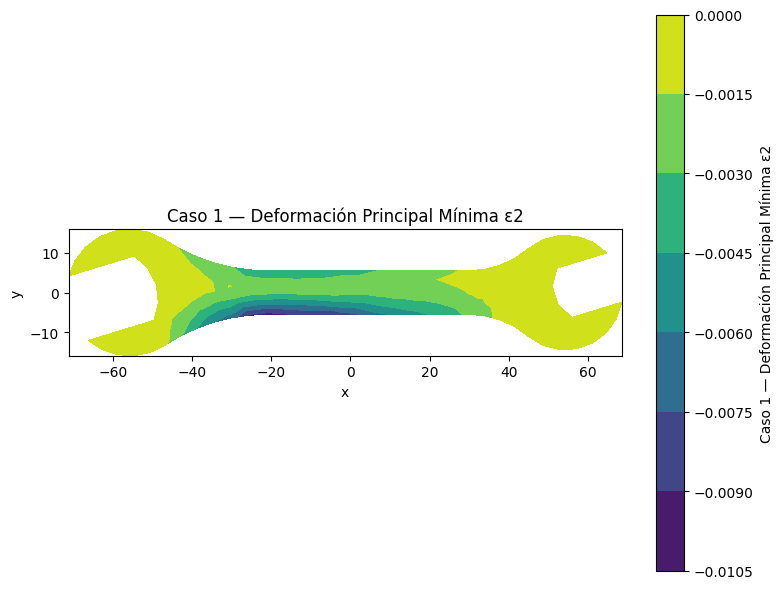

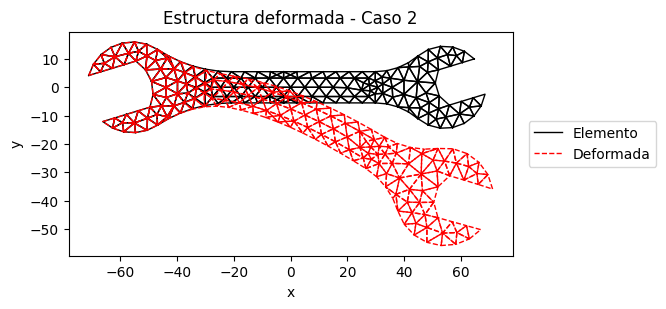

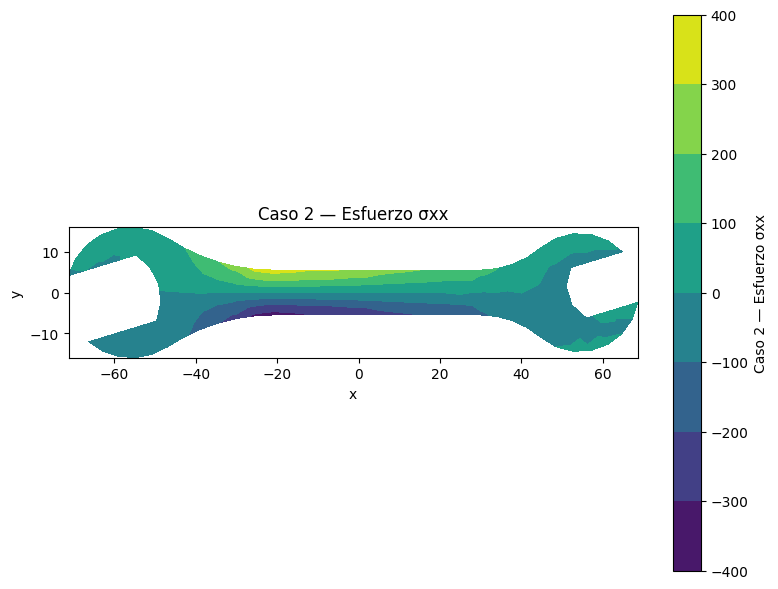

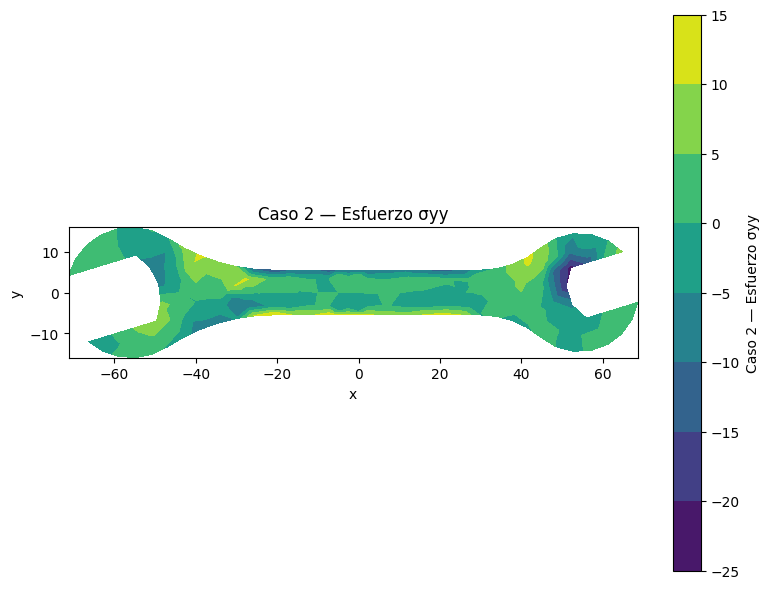

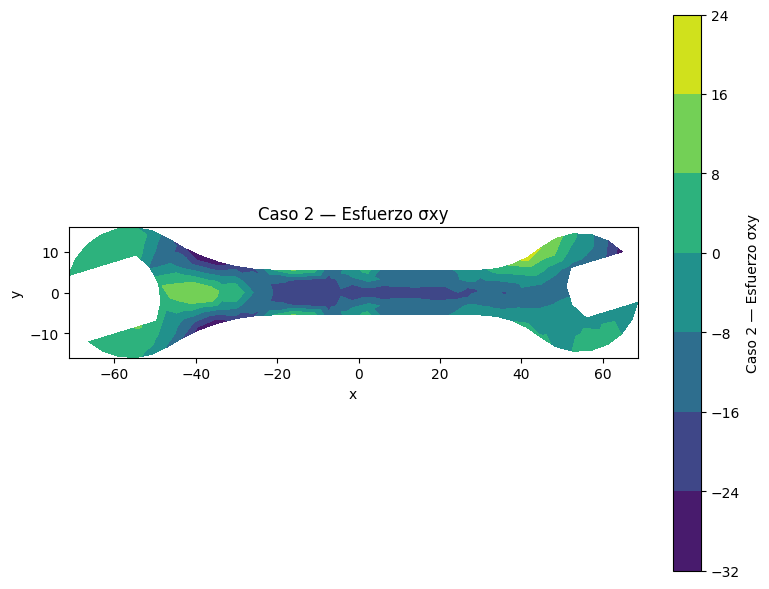

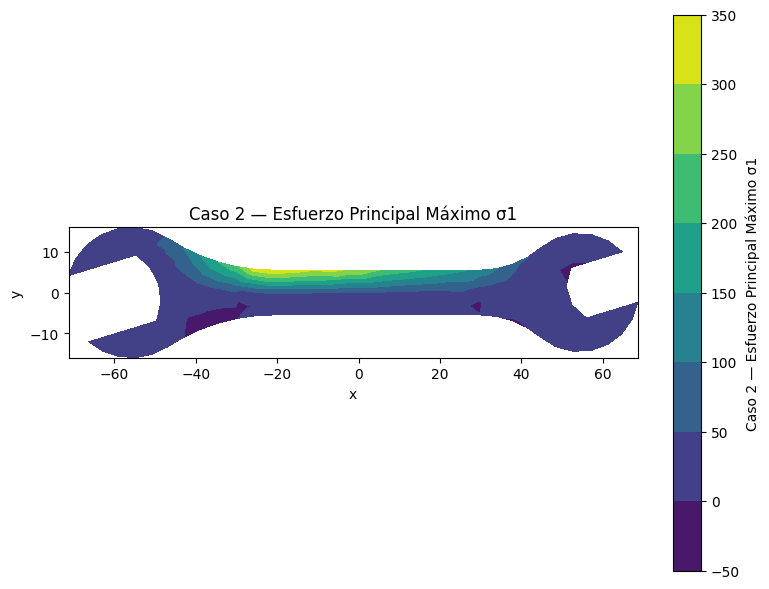

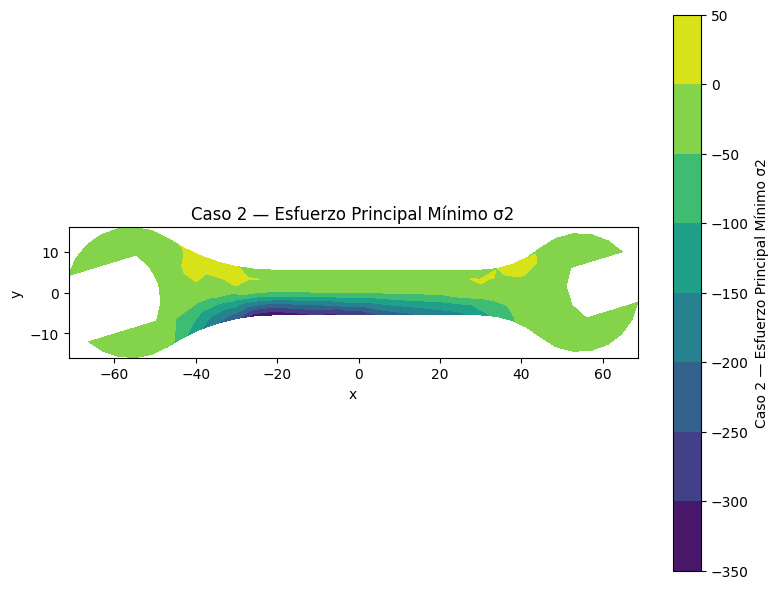

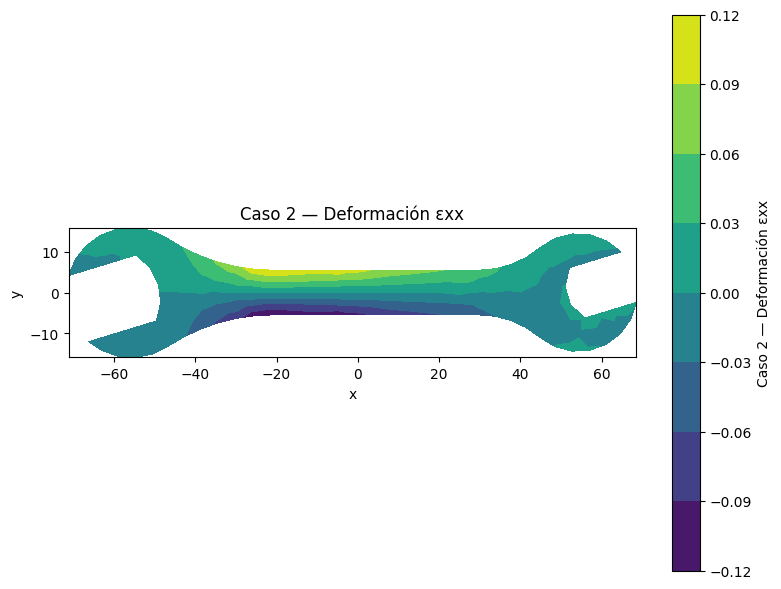

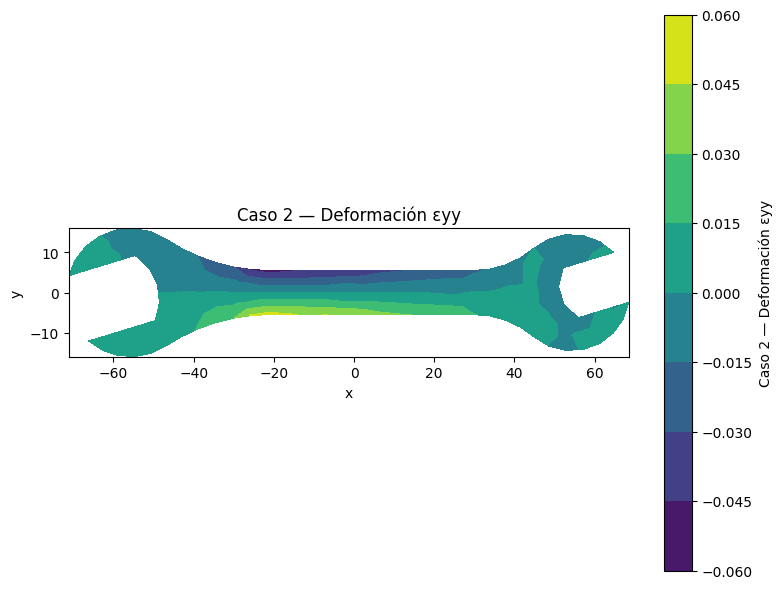

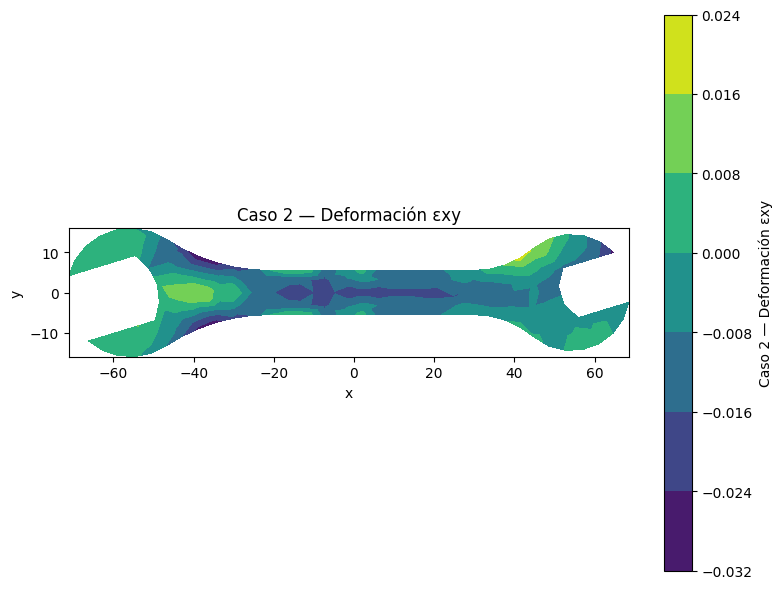

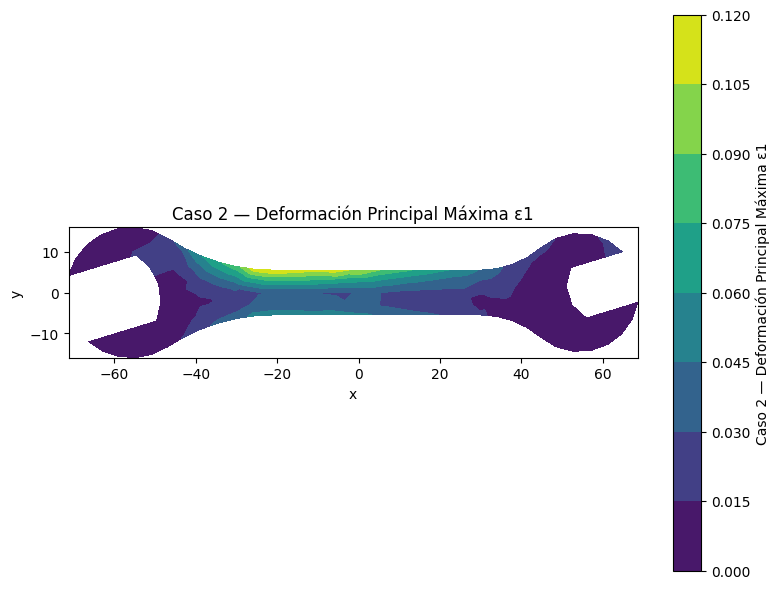

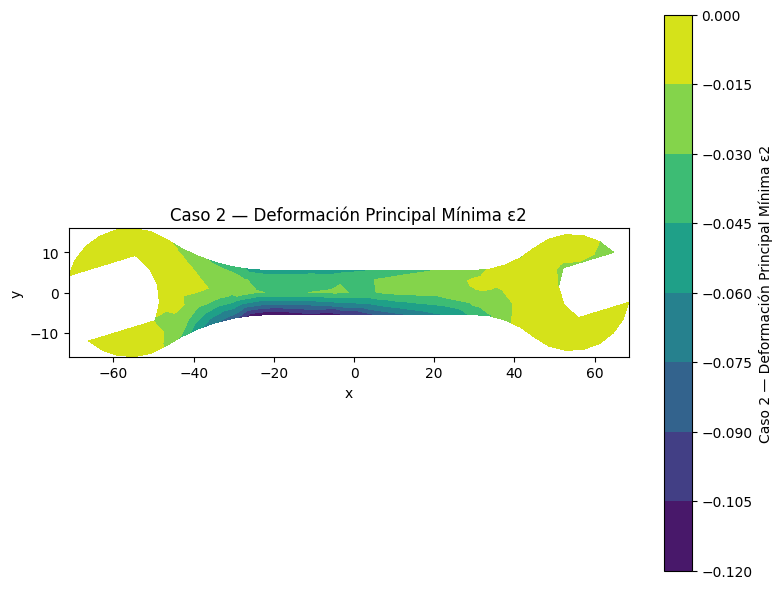

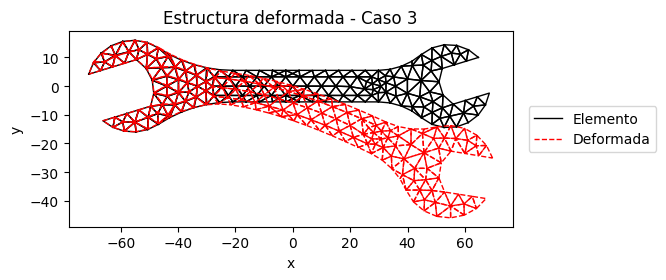

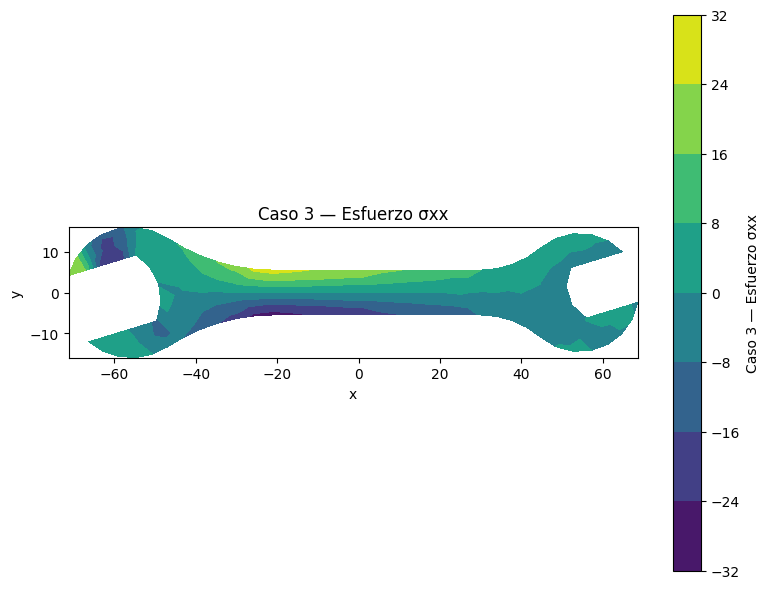

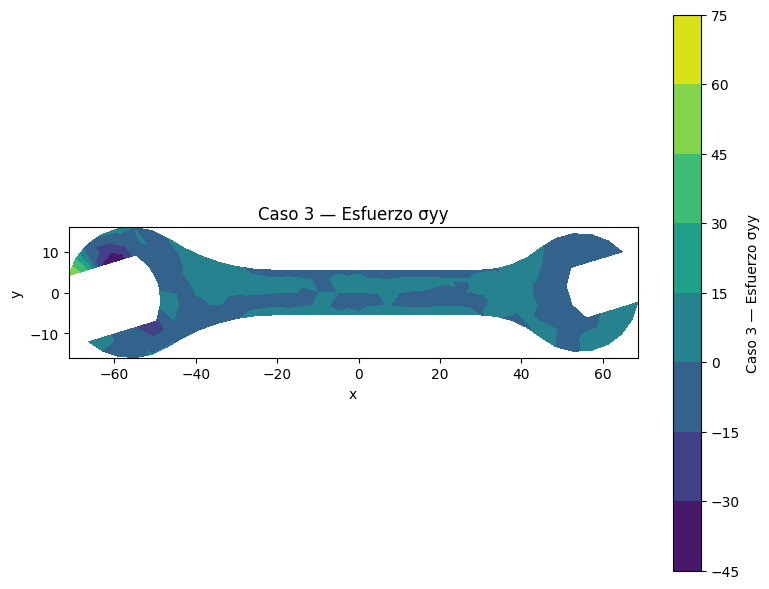

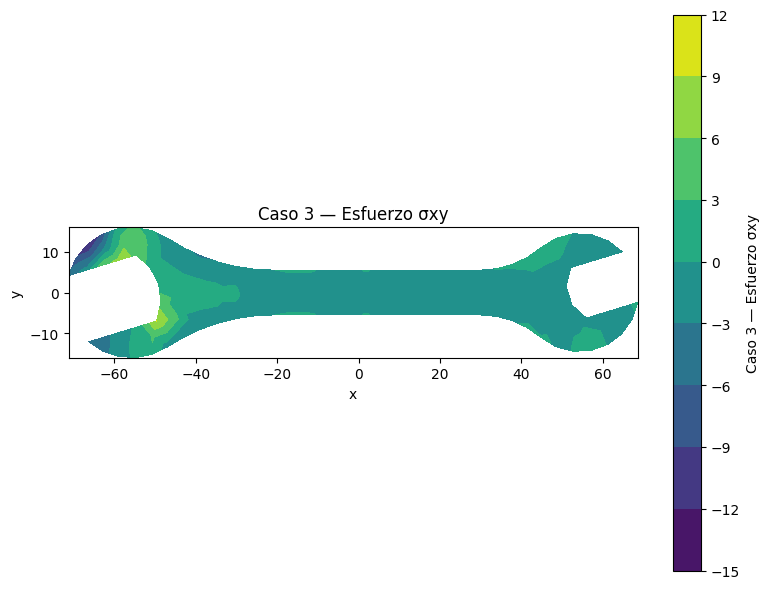

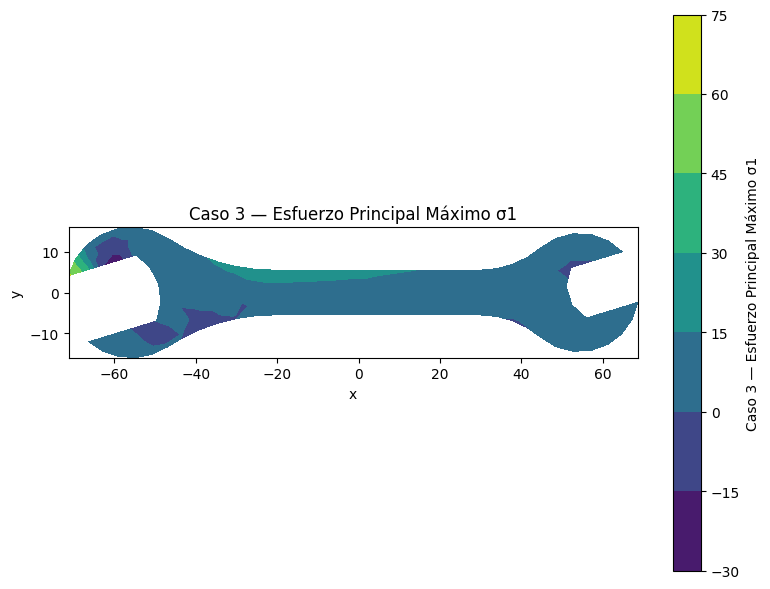

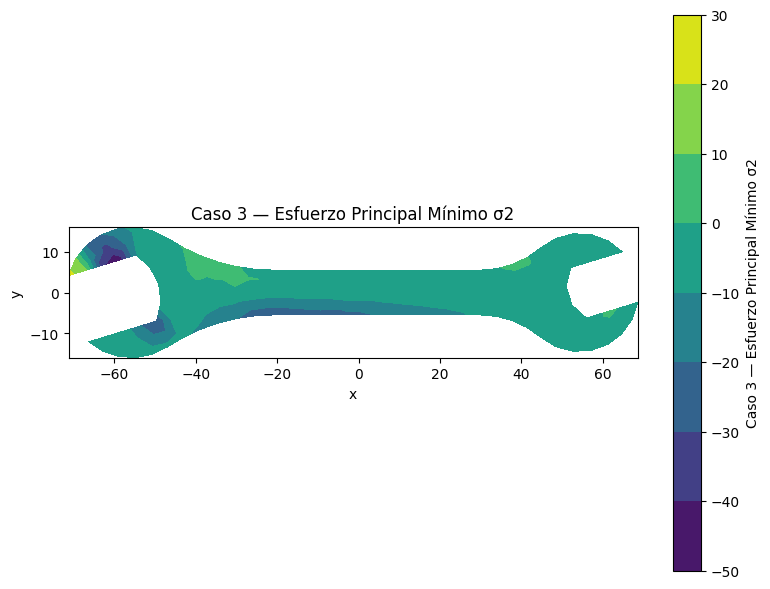

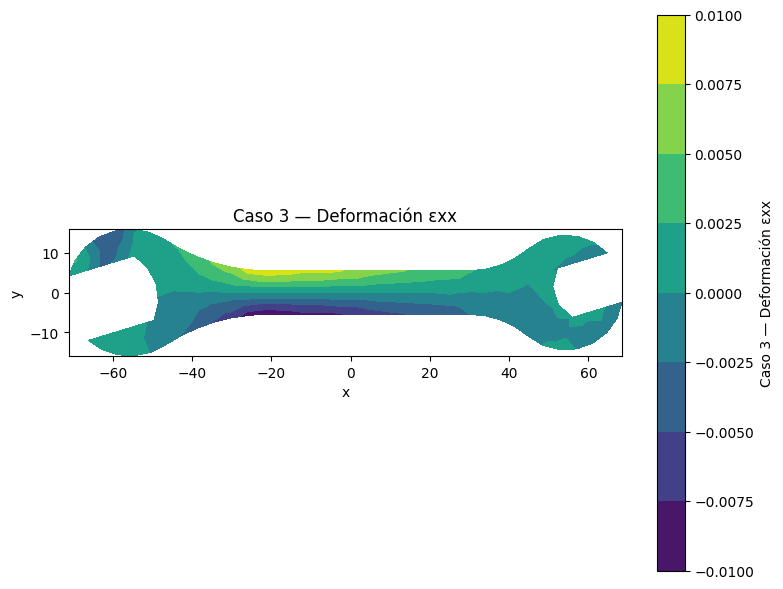

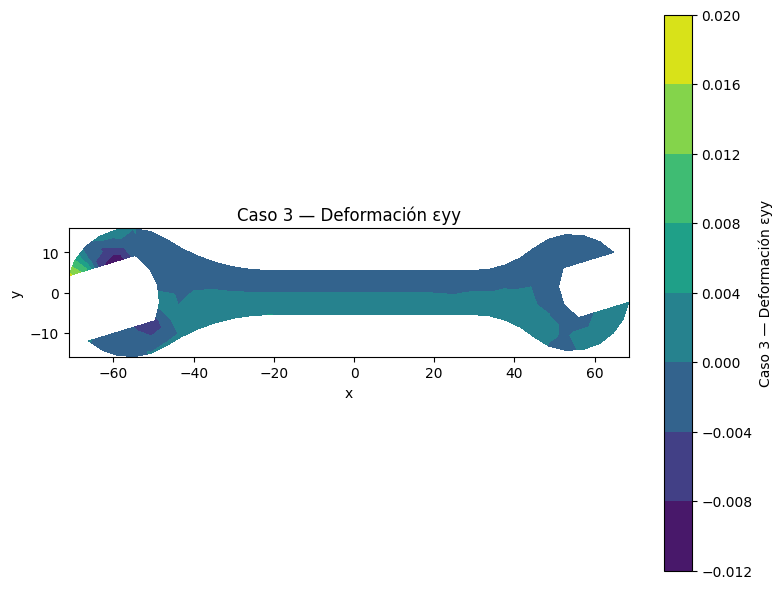

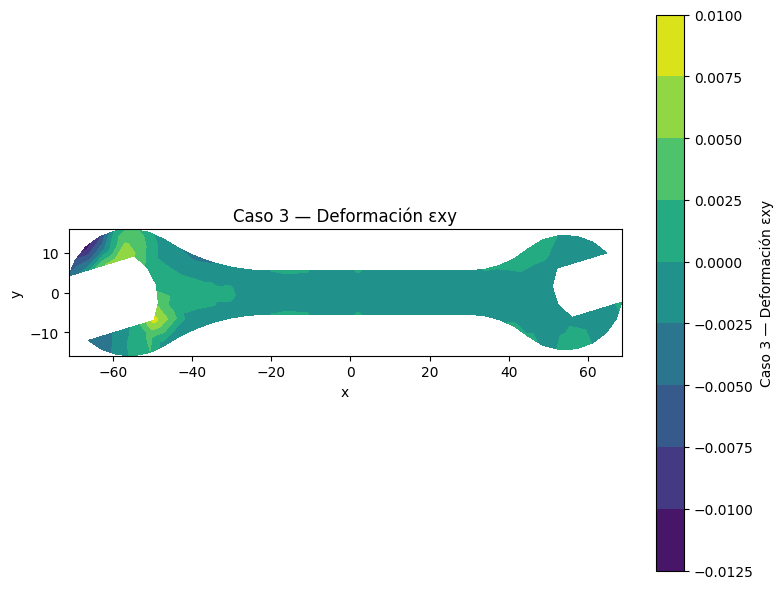

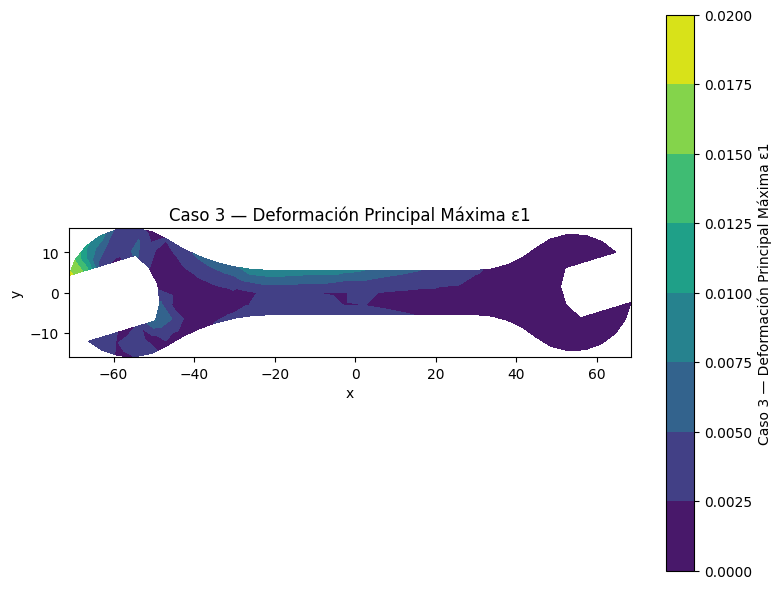

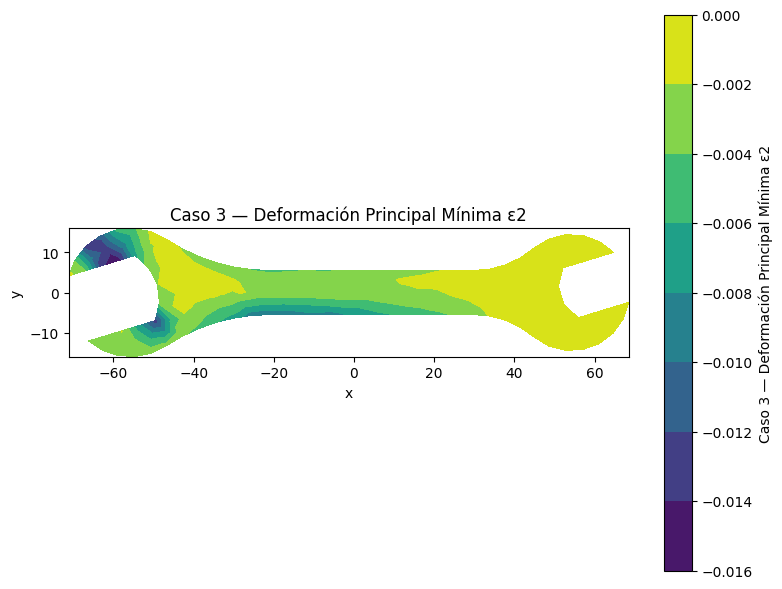

In [242]:
if "Force" in grupos:
    nodos_fuerza = grupos["Force"]
for i in range(3):
    if i == 0:
        apply_distributed_force(nodos_fuerza, fuerza_total_y=30*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=5, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
    elif i == 1:
        single_force(nodes, nodos_fuerza, fuerza_total_y=30*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=0.5, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
    elif i == 2:
        apply_distributed_force_especial(grupos, elements, fuerza_total_y=30*kgf)
        u=solve(nodes, elements)
        plot_deformed_shape(nodes, elements, u, i, scale=5, folder="Resultados")
        results = compute_stress_strain_components(elements, u)
        plot_all_fields(results, nodes, elements, i)
    for j in nodes:
        j.set_nodalLoad([0,0])


    


Ahora con los 3 casos listos, procedemos a ver el tema de la optimización de sección mantiniendo el volumen constante

In [243]:
def total_volume(elements):
    return sum(elem.area * elem.section.thickness for elem in elements)
V0 = total_volume(elements)
print(f"Volumen total de la estructura: {V0:.2f} mm³")

results = compute_stress_strain_components(elements, u)
sigma1_vals = [res["σ1"] for res in results]

ordered = sorted(zip(elements, sigma1_vals), key=lambda x: x[1], reverse=True)
def redistribute_thickness(elements, sigma1_vals, delta_t=0.2):
    max_index = np.argmax(sigma1_vals)
    min_index = np.argmin(sigma1_vals)

    # Aumentar espesor del más exigido
    elements[max_index].section.thickness += delta_t

    # Disminuir espesor del menos exigido
    tmin = elements[min_index].section.thickness
    elements[min_index].section.thickness = max(tmin - delta_t, 0.1)  # espesor mínimo

    # Reajustar globalmente si se altera el volumen
    V_actual = total_volume(elements)
    scale_factor = V0 / V_actual

    for elem in elements:
        elem.section.thickness *= scale_factor

Volumen total de la estructura: 16993.14 mm³


In [244]:
def optimize_structure(elements, nodes, u_init=None, max_iters=10, delta_t=0.2):
    # Volumen inicial
    V0 = total_volume(elements)
    print(f"📦 Volumen inicial: {V0:.2f} mm³")

    history = []

    for it in range(max_iters):
        print(f"\n🔁 Iteración {it+1}")

        # Resolver sistema para obtener desplazamientos actualizados
        u = solve(nodes, elements)

        # Calcular tensiones principales
        results = compute_stress_strain_components(elements, u)
        sigma1_vals = [res["σ1"] for res in results]

        # Guardar el máximo actual
        max_sigma = max(sigma1_vals)
        history.append(max_sigma)
        print(f"📈 σ1 máximo actual: {max_sigma:.2f} MPa")

        # Redistribuir espesores (solo una modificación por iteración)
        max_index = np.argmax(sigma1_vals)
        min_index = np.argmin(sigma1_vals)

        elements[max_index].section.thickness += delta_t

        tmin = elements[min_index].section.thickness
        elements[min_index].section.thickness = max(tmin - delta_t, 0.1)

        # Reajuste para mantener volumen
        V_actual = total_volume(elements)
        scale = V0 / V_actual
        for elem in elements:
            elem.section.thickness *= scale

    print("\n✅ Optimización completada.")
    return u, history

In [245]:
def plot_optimization_history(history):
    plt.figure()
    plt.plot(history, marker='o')
    plt.title("Evolución del σ1 máximo")
    plt.xlabel("Iteración")
    plt.ylabel("σ1 máximo (MPa)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

📦 Volumen inicial: 16993.14 mm³

🔁 Iteración 1
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 2
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 3
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 4
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 5
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 6
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 7
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 8
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 9
📈 σ1 máximo actual: 0.00 MPa

🔁 Iteración 10
📈 σ1 máximo actual: 0.00 MPa

✅ Optimización completada.


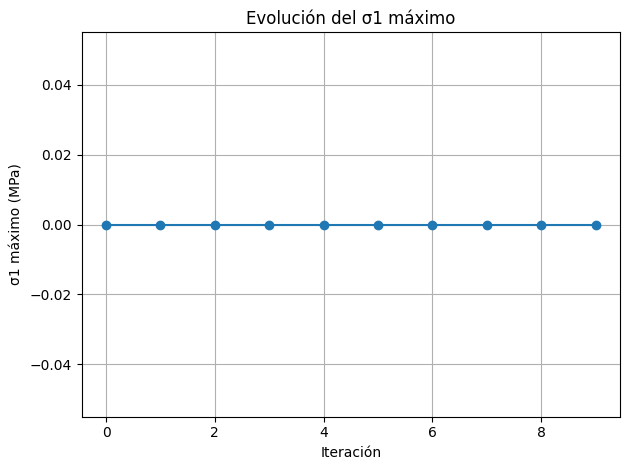

In [246]:
u_optimized, history = optimize_structure(elements, nodes, u, max_iters=10)
plot_optimization_history(history)